In [1]:
stock_name = "^GSPC"
date_predict_start = '2020-01-01'
data_range = 250
slide_range = 10
n_slide = 10
pv_range = 7
n_harm_lower_limit = 1
n_harm_upper_limit = 50
fit_method = 'rmse'
pv_method = 'CL'

base_day = 30
prediction_day = base_day
slide = base_day

profit_percentage = 0.1
loss_percentage = 0.1

# Import packages


In [2]:
import numpy as np
import pylab as pl
from numpy import fft
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
from dateutil.relativedelta import relativedelta
import math
import matplotlib.dates as mdates
import warnings
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm

# Load data


In [3]:
def load_data(stock_name, date_predict_start, data_range, slide_range, n_slide):
    train_data = {}
    test_data = {}
    date_predict_start = datetime.datetime.strptime(
        date_predict_start, '%Y-%m-%d').date()
    date_data_start_list = []
    date_predict_start_list = []
    date_predict_end_list = []
    test_data_start_list = []
    all_data = yf.Ticker(stock_name).history(period='max')
    all_data.index = all_data.index.date
    check = date_predict_start in all_data.index
    while (check == False):
        date_predict_start = date_predict_start + \
            relativedelta(days=+1)
        check = date_predict_start in list(all_data.index)
    predict_start = all_data.index.get_loc(date_predict_start)
    for i in range(n_slide):
        predict_end = predict_start + data_range
        date_predict_end = all_data.iloc[predict_end].name
        data_start = predict_start - data_range
        date_data_start = all_data.iloc[data_start].name
        train_data['data_' + str(i)] = all_data.iloc[data_start:predict_start]
        test_data['data_' + str(i)] = all_data.iloc[predict_start:predict_end]
        date_data_start_list.append(date_data_start)
        date_predict_start_list.append(date_predict_start)
        date_predict_end_list.append(date_predict_end)
        test_data_start_list.append(test_data['data_' + str(i)].index[0])
        data_start = data_start + slide_range
        predict_start = predict_start + slide_range
        train_data['data_' + str(i)] = train_data['data_' +
                                                  str(i)].reset_index(drop=False)
        test_data['data_' + str(i)] = test_data['data_' +
                                                str(i)].reset_index(drop=False)

    return train_data, test_data, all_data, test_data_start_list


# Data preprocessing


In [4]:
def find_data_pv_CL_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    for i in data:
        price = data[i]['Close']
        data[i]['peaks'] = pd.Series(dtype='float64')
        data[i]['valleys'] = pd.Series(dtype='float64')
        data[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(price)):
            if idx < pv_range:
                if price[idx] == price.iloc[0:pv_range*2+1].max():
                    data[i]['peaks'].iloc[idx] = price[idx]
                    data[i]['pv'].iloc[idx] = 'peak'
                if price[idx] == price.iloc[0:pv_range*2+1].min():
                    data[i]['valleys'].iloc[idx] = price[idx]
                    data[i]['pv'].iloc[idx] = 'valley'
            if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
                data[i]['peaks'].iloc[idx] = price[idx]
                data[i]['pv'].iloc[idx] = 'peak'
            if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
                data[i]['valleys'].iloc[idx] = price[idx]
                data[i]['pv'].iloc[idx] = 'valley'


In [5]:
def find_data_pv_HL_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    for i in data:
        high = data[i]['High']
        low = data[i]['Low']
        data[i]['peaks'] = pd.Series(dtype='float64')
        data[i]['valleys'] = pd.Series(dtype='float64')
        data[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(high)):
            if idx < pv_range and idx>0:
                if high[idx] == high.iloc[0:pv_range*2+1].max():
                    data[i]['peaks'].iloc[idx] = high[idx]
                    data[i]['pv'].iloc[idx] = 'peak'
                if low[idx] == low.iloc[0:pv_range*2+1].min():
                    data[i]['valleys'].iloc[idx] = low[idx]
                    data[i]['pv'].iloc[idx] = 'valley'
            if high[idx] == high.iloc[idx-pv_range:idx+pv_range].max():
                data[i]['peaks'].iloc[idx] = high[idx]
                data[i]['pv'].iloc[idx] = 'peak'
            if low[idx] == low.iloc[idx-pv_range:idx+pv_range].min():
                data[i]['valleys'].iloc[idx] = low[idx]
                data[i]['pv'].iloc[idx] = 'valley'


In [6]:
def preprocessing(train_data, test_data, pv_range, pv_method):
    if pv_method == 'CL':
        find_data_pv_CL_function(train_data, pv_range)
        find_data_pv_CL_function(test_data, pv_range)
    elif pv_method == 'HL':
        find_data_pv_HL_function(train_data, pv_range)
        find_data_pv_HL_function(test_data, pv_range)
    else :
        print('worng pv_method')


# Built Model


Get signal


In [7]:
def data_to_harmonics_function(data_stock, data_range):
    harmonics = {}
    for i in data_stock:
        harmonics[i] = {}
        # get data_stock's infomation
        data = data_stock[i]['Close']
        array_data = np.array(data)
        n_data = array_data.size
        time_data = np.arange(0, n_data)

        # detrend data
        # find linear trend in data
        Polynomial = np.polyfit(time_data, array_data, 1)
        data_notrend = array_data - Polynomial[0] * time_data    # detrended x

        # fft process
        data_freqdom = fft.fft(data_notrend, n=n_data)
        frequence = fft.fftfreq(n=n_data, d=1)
        f_positive = frequence[np.where(frequence > 0)]
        data_freqdom_positive = data_freqdom[np.where(frequence > 0)]

        # sort indexes
        indexes = list(range(f_positive.size))      # frequencies
        # sort method 1
        # indexes.sort(key = lambda i: np.absolute(frequence[i]))     # sort indexes by frequency, lower -> higher
        # sort method 2 :
        # sort indexes by amplitudes, lower -> higher
        indexes.sort(key=lambda i: np.absolute(data_freqdom[i]))
        indexes.reverse()       # sort indexes by amplitudes, higher -> lower

        # get data_all_time'size
        time_transfer = np.arange(0, data_range*2)

        # get harmonics
        for j in indexes:
            ampli = np.absolute(
                data_freqdom_positive[j]) / n_data     # amplitude
            phase = np.angle(data_freqdom_positive[j])      # phase
            harmonics[i][j] = ampli * \
                np.cos(2 * np.pi * f_positive[j] * time_transfer + phase)
    return harmonics


In [8]:
def mix_harmonics_function(harmonics, n_harm_lower_limit, n_harm_upper_limit):
    processed_signal = {}
    for i in harmonics:
        processed_signal[i] = {}
        for n_harm in range(n_harm_lower_limit, n_harm_upper_limit+1):
            mixed_harmonic = np.zeros(len(harmonics[i][0]))
            # for j in range(n_harm):
            for j in range(2, n_harm):
                mixed_harmonic += harmonics[i][j]
            processed_signal[i][n_harm] = pd.DataFrame(
                {'Close': mixed_harmonic})
    return processed_signal


Signal processing


In [9]:
def find_signal_pv_function(signal, pv_range):
    pd.options.mode.chained_assignment = None
    for i in signal:
        for j in signal[i]:
            data = signal[i][j]['Close']
            signal[i][j]['peaks'] = pd.Series(dtype='float64')
            signal[i][j]['valleys'] = pd.Series(dtype='float64')
            signal[i][j]['pv'] = pd.Series(dtype='str')
            for idx in range(0, len(data)):
                if idx < pv_range and idx>0:
                    if data[idx] == data.iloc[0:pv_range*2+1].max():
                        signal[i][j]['peaks'].iloc[idx] = data[idx]
                        signal[i][j]['pv'].iloc[idx] = 'peak'
                    if data[idx] == data.iloc[0:pv_range*2+1].min():
                        signal[i][j]['valleys'].iloc[idx] = data[idx]
                        signal[i][j]['pv'].iloc[idx] = 'valley'
                if data[idx] == data.iloc[idx-pv_range:idx+pv_range].max():
                    signal[i][j]['peaks'].iloc[idx] = data[idx]
                    signal[i][j]['pv'].iloc[idx] = 'peak'
                if data[idx] == data.iloc[idx-pv_range:idx+pv_range].min():
                    signal[i][j]['valleys'].iloc[idx] = data[idx]
                    signal[i][j]['pv'].iloc[idx] = 'valley'


In [10]:
def find_signal_lead_train_function(data, processed_signal):
    for d in data:
        for p in processed_signal[d]:
            # processed_signal[d][p]['pv'] = pd.Series(dtype='str')
            processing_signal = processed_signal[d][p].head(len(data[d]))
            p_data = pd.DataFrame(
                {'peaks': data[d]['peaks'], 'count': range(len(data[d]))})
            p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
            p_data_count = list(p_data['count'])
            p_signal = pd.DataFrame(
                {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
            p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
            p_signal_list = list(p_signal['count'])
            p_lead = []
            for i in range(0, len(p_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(p_data_count)):
                    temp.append((p_data_count[j] - p_signal_list[i]))
                    temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                p_lead.append(temp_2)
            p_signal['lead'] = p_lead

            v_data = pd.DataFrame(
                {'valleys': data[d]['valleys'], 'count': range(len(data[d]))})
            v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
            v_data_count = list(v_data['count'])
            v_signal = pd.DataFrame(
                {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
            v_signal = v_signal.drop(
                v_signal[v_signal['valleys'].isna()].index)
            v_signal_list = list(v_signal['count'])
            v_lead = []
            for i in range(0, len(v_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(v_data_count)):
                    temp.append((v_data_count[j] - v_signal_list[i]))
                    temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                v_lead.append(temp_2)
            v_signal['lead'] = v_lead

            processed_signal[d][p]['lead'] = pd.Series(dtype='float64')
            processed_signal[d][p]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
            processed_signal[d][p]['lead'].loc[v_signal['lead'].index] = v_signal['lead']


In [11]:
def build_model(train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range):
    harmonics = data_to_harmonics_function(train_data, data_range)
    processed_signal = mix_harmonics_function(
        harmonics, n_harm_lower_limit, n_harm_upper_limit)
    find_signal_pv_function(processed_signal, pv_range)
    find_signal_lead_train_function(train_data, processed_signal)
    return harmonics, processed_signal


# Select model


In [12]:
def get_fit_error_function(processed_signal, fit_method):
    errors = {}
    error = []
    for i in processed_signal:
        errors[i] = {}
        for j in processed_signal[i]:
            signal_dropna = processed_signal[i][j].drop(
                processed_signal[i][j][processed_signal[i][j]['lead'].isna()].index)
            if fit_method == 'mean':
                error = signal_dropna['lead'].mean()
            elif fit_method == 'abs':
                error = abs(signal_dropna['lead']).mean()
            elif fit_method == 'rmse':
                mse = np.square(np.subtract(np.zeros_like(
                    signal_dropna['lead']), signal_dropna['lead'])).mean()
                rmse = math.sqrt(mse)
                error = rmse
            else :
                print('worng fit_method')
            errors[i][j] = error
    return errors


In [13]:
def get_best_fit_harm_function(processed_signal, errors):
    best_error = {}
    best_fit_harm = {}
    for i in processed_signal:
        best_error[i] = pd.Series(errors[i]).abs().min()
        best_fit_harm[i] = pd.Series(errors[i]).abs().idxmin()
    return best_fit_harm, best_error


In [14]:
def find_signal_lead_test_function(data, processed_signal):
    for d in data:
        for p in processed_signal[d]:
            processed_signal[d][p]['pv'] = pd.Series(dtype='str')
            processing_signal = processed_signal[d][p].tail(len(data[d]))
            p_data = pd.DataFrame(
                {'peaks': data[d]['peaks'], 'count': range(len(data[d]))})
            p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
            p_data_count = list(p_data['count'])
            p_signal = pd.DataFrame(
                {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
            p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
            p_signal_list = list(p_signal['count'])
            p_lead = []
            for i in range(0, len(p_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(p_data_count)):
                    temp.append((p_data_count[j] - p_signal_list[i]))
                    temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                p_lead.append(temp_2)
            p_signal['lead'] = p_lead

            v_data = pd.DataFrame(
                {'valleys': data[d]['valleys'], 'count': range(len(data[d]))})
            v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
            v_data_count = list(v_data['count'])
            v_signal = pd.DataFrame(
                {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
            v_signal = v_signal.drop(
                v_signal[v_signal['valleys'].isna()].index)
            v_signal_list = list(v_signal['count'])
            v_lead = []
            for i in range(0, len(v_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(v_data_count)):
                    temp.append((v_data_count[j] - v_signal_list[i]))
                    temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                v_lead.append(temp_2)
            v_signal['lead'] = v_lead

            processed_signal[d][p]['lead'] = pd.Series(dtype='float64')
            processed_signal[d][p]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
            processed_signal[d][p]['pv'].loc[p_signal['lead'].index] = 'peak'
            processed_signal[d][p]['lead'].loc[v_signal['lead'].index] = v_signal['lead']
            processed_signal[d][p]['pv'].loc[v_signal['lead'].index] = 'valley'


In [15]:
def get_first_lead_function(processed_signal, best_fit_harm):
    first_date = {}
    lead = {}
    pv = {}
    for i in processed_signal:
        harm = best_fit_harm[i]
        temp = processed_signal[i][harm].loc[list(
            processed_signal[i][harm]['lead'].dropna().index)[0]]
        first_date[i] = list(processed_signal[i][harm]
                             ['lead'].dropna().index)[0]
        lead[i] = temp['lead']
        pv[i] = temp['pv']
    return first_date, lead, pv


In [16]:
def select_model(test_data, processed_signal, fit_method):
    errors = get_fit_error_function(processed_signal, fit_method)
    best_fit_harm, best_error = get_best_fit_harm_function(
        processed_signal, errors)
    find_signal_lead_test_function(test_data, processed_signal)
    first_date, lead, pv = get_first_lead_function(
        processed_signal, best_fit_harm)
    return errors, best_fit_harm, best_error, first_date, lead, pv


# Evaluate model


In [17]:
def built_result_table_function(processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm):
    result_table = pd.DataFrame(columns=[
        's_date', 't_date', 'lead', 'ans_date', 'pv', 'error', 'best_fit'])
    for i in processed_signal:
        result_table.loc[i, 'error'] = round(best_error[i], 2)
        result_table.loc[i, 'best_fit'] = best_fit_harm[i]
        result_table.loc[i, 'lead'] = lead[i]
        result_table.loc[i, 'pv'] = pv[i]
    result_table['s_date'] = test_data_start_list
    return result_table


In [18]:
def result_table_process_function(result_table, all_data, first_date, data_range):
    for i in result_table.index:
        t_date = all_data.iloc[all_data.index.get_loc(result_table.loc[i, 's_date']) + first_date[i] - data_range].name
        result_table.loc[i, 't_date'] = t_date
        ans = all_data.iloc[int(all_data.index.get_loc(t_date) + result_table.loc[i, 'lead'])].name
        result_table.loc[i, 'ans_date'] = ans

In [19]:
def compute_final_error_function(result_table):
    final_error = round(
        sum([abs(ele) for ele in result_table['lead']]) / len(result_table['lead']), 2)
    return final_error


In [20]:
def evaluate_model(processed_signal, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range):
    result_table = built_result_table_function(
        processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm)
    result_table_process_function(
        result_table, all_data, first_date, data_range)
    final_error = compute_final_error_function(result_table)
    return result_table, final_error


# Draw plot


In [21]:
def find_data_pv_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    price = data['Close']
    data['peaks'] = pd.Series(dtype='float64')
    data['valleys'] = pd.Series(dtype='float64')
    data['pv'] = pd.Series(dtype='str')
    for idx in range(0, len(price)):
        if idx < pv_range and idx>0:
            if price[idx] == price.iloc[0:pv_range*2+1].max():
                data['peaks'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'peak'
            if price[idx] == price.iloc[0:pv_range*2+1].min():
                data['valleys'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'valleys'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
            data['peaks'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'peak'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
            data['valleys'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'valleys'


In [22]:
def draw_plot_result_table(test_data, all_data, result_table, pv_range):
    date_list = sorted(
        list(result_table['s_date']) + list(result_table['t_date']) + list(result_table['ans_date']))
    all_index = all_data.loc[date_list[0]:date_list[-1]].index
    fig, axes = plt.subplots(2, 1, figsize=(30, 8), sharex=True)
    test_data_copy = test_data.copy()
    for d in test_data :
        test_data_copy[d].index = test_data[d]['index']
        test_data_copy[d] = test_data_copy[d].drop(test_data_copy[d][test_data_copy[d].index > date_list[-1]].index)
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['Close'], 'gray', label='data', linewidth=3)
    for d in test_data_copy :
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['peaks'],
                    '^', c='royalblue', label='peaks')
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['valleys'], 'v',
                    c='orangered', label='valleys')
    plot_model = pd.DataFrame(index=all_index, columns=[
                                's_date', 't_date', 'ans_date', 'lead', 'pv'])
    plot_model['s_date'].loc[result_table['s_date']] = True
    plot_model['t_date'].loc[result_table['t_date']] = True
    plot_model['lead'].loc[result_table['t_date']] = list(result_table['lead'])
    plot_model['pv'].loc[result_table['t_date']] = list(result_table['pv'])
    plot_model['ans_date'].loc[result_table['ans_date']] = True
    for i, label in enumerate(plot_model['lead']):
        if plot_model['pv'][i] == 'peak':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], '^',
                            c='royalblue')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)
        elif plot_model['pv'][i] == 'valley':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], 'v',
                            c='orangered')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)

    axes[0].set_ylabel("Stock price", fontsize=14)
    axes[0].grid(True)
    axes[1].grid(True)
    axes[1].set_ylabel("lead", fontsize=14)
    plt.show()

# Main function


In [23]:
def main_funtion(
    stock_name, date_predict_start, data_range, slide_range,
        n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method):

    # 1. Load data
    train_data, test_data, all_data, test_data_start_list = load_data(
        stock_name, date_predict_start, data_range, slide_range, n_slide)
    # 2. Preprocessing
    preprocessing(train_data, test_data, pv_range, pv_method)
    # 3. Build model
    harmonics, model = build_model(
        train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range)
    # 4. Select model
    errors, best_fit_harm, best_error, first_date, lead, pv = select_model(test_data,
                                                                           model, fit_method)
    # 5. Evaluate model
    result_table, final_error = evaluate_model(
        model, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range)
    print('final_error = ', final_error)
    with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
        print(result_table)
    draw_plot_result_table(test_data, all_data, result_table, pv_range)
    # return harmonics, model, errors, best_fit_harm, best_error, first_date, lead, pv, result_table, final_error


In [24]:
# main_funtion(
#     stock_name, date_predict_start, data_range, slide_range,
#         n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method)

# Lstm function

In [25]:
def preprocessing_train_data_Lstm(train_data, base_day, prediction_day, slide):
    x_train = {}
    y_train = {}
    for i in train_data:
        scaler = MinMaxScaler(feature_range=(-1,1))
        scaled_data = scaler.fit_transform(train_data[i]['Close'].values.reshape(-1,1))
        x_train[i] = []
        y_train[i] = []
        # for x in range(base_day+prediction_day, len(scaled_data), slide):
        for x in range(base_day+prediction_day, len(scaled_data)):
            x_train[i].append(scaled_data[x-base_day-prediction_day:x-prediction_day])
            y_train[i].append(scaled_data[x-prediction_day:x])
        x_train[i], y_train[i] = np.array(x_train[i]), np.array(y_train[i])
        # 將x_train數組的形狀轉換為（樣本數，天數，特徵數）的形式，這裡的特徵數為1
        x_train[i] = np.reshape(x_train[i], (x_train[i].shape[0], x_train[i].shape[1], 1))
        y_train[i] = np.reshape(y_train[i], (y_train[i].shape[0], y_train[i].shape[1], 1))
    return x_train, y_train

In [26]:
def LSTM_model(prediction_day, input_shape):
    model = Sequential()
    model.add(LSTM(units = 256, return_sequences = True, input_shape = input_shape))
    model.add(Dropout(0.4))
    model.add(LSTM(units = 128, return_sequences = True))
    model.add(Dropout(0.4))
    model.add(LSTM(units = 64))
    model.add(Dropout(0.4))
    model.add(Dense(units=prediction_day))
    return model

In [27]:
def build_Lstm_model(train_data, prediction_day, input_shape):
    model = {}
    for i in train_data:
        model[i] = LSTM_model(prediction_day, input_shape)
        model[i].compile(optimizer='adam', 
                    loss='mean_squared_error')
        # model[i].summary()
    return model

In [28]:
def train_Lstm_model(train_data, model, x_train, y_train):
    history = {}
    for i in tqdm(train_data):
        earlystopper = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 2)
        history[i] = model[i].fit(x_train[i], y_train[i], epochs=25, batch_size=32, 
                            callbacks = [earlystopper], validation_split = 0.2, shuffle=True)
    return history

In [29]:
def preprocessing_test_data_Lstm(train_data, test_data, base_day, prediction_day, slide):
    x_test = {}
    y_test = {}
    for i in test_data:
        scaler = MinMaxScaler(feature_range=(-1,1))
        model_inputs = pd.concat((train_data[i]['Close'].iloc[-base_day:], test_data[i]['Close'])).values
        model_inputs = model_inputs.reshape(-1,1)
        model_inputs = scaler.fit_transform(model_inputs)
        x_test[i] = []
        y_test[i] = []
        for x in range(base_day+prediction_day, len(model_inputs), slide):
            x_test[i].append(model_inputs[x-base_day-prediction_day:x-prediction_day])
            y_test[i].append(model_inputs[x-prediction_day:x])
        x_test[i], y_test[i] = np.array(x_test[i]), np.array(y_test[i])
        x_test[i] = np.reshape(x_test[i], (x_test[i].shape[0], x_test[i].shape[1], 1))
        y_test[i] = np.reshape(y_test[i], (y_test[i].shape[0], y_test[i].shape[1], 1))
    return x_test, y_test

In [30]:
def predicting_creat_processed_signal_Lstm(x_test, test_data, model):
    processed_signal = {}
    for i in test_data:
        predicted_prices = model[i].predict(x_test[i])
        processed_signal[i] = {}
        processed_signal[i][0] = pd.DataFrame(
            {'Close': predicted_prices.flatten()}, index=test_data[i].index[:len(predicted_prices.flatten())])
    return processed_signal

In [31]:
def result_table_process_Lstm_function(result_table, all_data, first_date, data_range):
    for i in result_table.index:
        t_date = all_data.iloc[int(all_data.index.get_loc(result_table.loc[i, 's_date'])) + first_date[i]].name
        result_table.loc[i, 't_date'] = t_date
        ans = all_data.iloc[int(all_data.index.get_loc(t_date) + result_table.loc[i, 'lead'])].name
        result_table.loc[i, 'ans_date'] = ans

In [32]:
# 1. Load data
train_data, test_data, all_data, test_data_start_list = load_data(
    stock_name, date_predict_start, data_range, slide_range, n_slide)
# 2. Preprocessing
preprocessing(train_data, test_data, pv_range, pv_method)
x_train, y_train = preprocessing_train_data_Lstm(train_data, base_day, prediction_day, slide)
x_test, y_test = preprocessing_test_data_Lstm(train_data, test_data, base_day, prediction_day, slide)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/25
5/5 [==============================] - 9s 644ms/step - loss: 0.0406 - val_loss: 0.2406
Epoch 2/25
5/5 [==============================] - 1s 205ms/step - loss: 0.0347 - val_loss: 0.1987
Epoch 3/25
5/5 [==============================] - 1s 203ms/step - loss: 0.0333 - val_loss: 0.1918
Epoch 4/25
5/5 [==============================] - 1s 212ms/step - loss: 0.0314 - val_loss: 0.2126
Epoch 5/25
5/5 [==============================] - 1s 214ms/step - loss: 0.0307 - val_loss: 0.1873
Epoch 6/25
5/5 [==============================] - 1s 209ms/step - loss: 0.0291 - val_loss: 0.2176
Epoch 7/25
5/5 [==============================] - 1s 218ms/step - loss: 0.0288 - val_loss: 0.2002
Epoch 8/25
5/5 [==============================] - 1s 212ms/step - loss: 0.0276 - val_loss: 0.2233
Epoch 9/25
5/5 [==============================] - 1s 212ms/step - loss: 0.0269 - val_loss: 0.2221
Epoch 10/25
5/5 [==============================] - 1s 213ms/step - loss: 0.0262 - val_loss: 0.1835
Epoch 11/25
5/5 [==

 10%|█         | 1/10 [00:27<04:11, 27.94s/it]

Epoch 1/25
5/5 [==============================] - 13s 1s/step - loss: 0.0503 - val_loss: 0.2689
Epoch 2/25
5/5 [==============================] - 1s 182ms/step - loss: 0.0435 - val_loss: 0.2700
Epoch 3/25
5/5 [==============================] - 1s 159ms/step - loss: 0.0420 - val_loss: 0.2682
Epoch 4/25
5/5 [==============================] - 1s 168ms/step - loss: 0.0423 - val_loss: 0.2648
Epoch 5/25
5/5 [==============================] - 1s 154ms/step - loss: 0.0403 - val_loss: 0.2684
Epoch 6/25
5/5 [==============================] - 1s 172ms/step - loss: 0.0398 - val_loss: 0.2670
Epoch 7/25
5/5 [==============================] - 1s 171ms/step - loss: 0.0382 - val_loss: 0.2430
Epoch 8/25
5/5 [==============================] - 1s 167ms/step - loss: 0.0382 - val_loss: 0.2581
Epoch 9/25
5/5 [==============================] - 1s 165ms/step - loss: 0.0369 - val_loss: 0.2764
Epoch 10/25
5/5 [==============================] - 1s 164ms/step - loss: 0.0360 - val_loss: 0.2592
Epoch 11/25
5/5 [====

 20%|██        | 2/10 [00:50<03:16, 24.52s/it]

Epoch 1/25
5/5 [==============================] - 11s 583ms/step - loss: 0.1038 - val_loss: 0.3070
Epoch 2/25
5/5 [==============================] - 1s 154ms/step - loss: 0.0745 - val_loss: 0.2876
Epoch 3/25
5/5 [==============================] - 1s 154ms/step - loss: 0.0698 - val_loss: 0.3041
Epoch 4/25
5/5 [==============================] - 1s 153ms/step - loss: 0.0657 - val_loss: 0.2997
Epoch 5/25
5/5 [==============================] - 1s 155ms/step - loss: 0.0607 - val_loss: 0.3001
Epoch 6/25
5/5 [==============================] - 1s 155ms/step - loss: 0.0584 - val_loss: 0.2936
Epoch 7/25
5/5 [==============================] - 1s 153ms/step - loss: 0.0587 - val_loss: 0.2734
Epoch 8/25
5/5 [==============================] - 1s 152ms/step - loss: 0.0555 - val_loss: 0.2792
Epoch 9/25
5/5 [==============================] - 1s 167ms/step - loss: 0.0528 - val_loss: 0.2547
Epoch 10/25
5/5 [==============================] - 1s 173ms/step - loss: 0.0562 - val_loss: 0.2781
Epoch 11/25
5/5 [=

 30%|███       | 3/10 [01:21<03:14, 27.81s/it]

Epoch 1/25
5/5 [==============================] - 17s 528ms/step - loss: 0.1615 - val_loss: 0.2810
Epoch 2/25
5/5 [==============================] - 1s 150ms/step - loss: 0.1154 - val_loss: 0.2859
Epoch 3/25
5/5 [==============================] - 1s 149ms/step - loss: 0.1021 - val_loss: 0.2601
Epoch 4/25
5/5 [==============================] - 1s 149ms/step - loss: 0.1010 - val_loss: 0.2702
Epoch 5/25
5/5 [==============================] - 1s 151ms/step - loss: 0.0884 - val_loss: 0.2558
Epoch 6/25
5/5 [==============================] - 1s 148ms/step - loss: 0.0847 - val_loss: 0.2507
Epoch 7/25
5/5 [==============================] - 1s 148ms/step - loss: 0.0783 - val_loss: 0.2251
Epoch 8/25
5/5 [==============================] - 1s 160ms/step - loss: 0.0760 - val_loss: 0.2062
Epoch 9/25
5/5 [==============================] - 1s 160ms/step - loss: 0.0749 - val_loss: 0.1889
Epoch 10/25
5/5 [==============================] - 1s 162ms/step - loss: 0.0740 - val_loss: 0.1821
Epoch 11/25
5/5 [=

 40%|████      | 4/10 [01:58<03:08, 31.34s/it]

Epoch 1/25
5/5 [==============================] - 11s 544ms/step - loss: 0.1458 - val_loss: 0.3474
Epoch 2/25
5/5 [==============================] - 1s 180ms/step - loss: 0.1096 - val_loss: 0.3273
Epoch 3/25
5/5 [==============================] - 1s 144ms/step - loss: 0.0976 - val_loss: 0.3087
Epoch 4/25
5/5 [==============================] - 1s 149ms/step - loss: 0.0923 - val_loss: 0.2712
Epoch 5/25
5/5 [==============================] - 1s 147ms/step - loss: 0.0865 - val_loss: 0.2472
Epoch 6/25
5/5 [==============================] - 1s 144ms/step - loss: 0.0810 - val_loss: 0.2008
Epoch 7/25
5/5 [==============================] - 1s 160ms/step - loss: 0.0803 - val_loss: 0.1558
Epoch 8/25
5/5 [==============================] - 1s 182ms/step - loss: 0.0763 - val_loss: 0.1284
Epoch 9/25
5/5 [==============================] - 1s 181ms/step - loss: 0.0746 - val_loss: 0.1038
Epoch 10/25
5/5 [==============================] - 1s 237ms/step - loss: 0.0724 - val_loss: 0.0805
Epoch 11/25
5/5 [=

 50%|█████     | 5/10 [02:24<02:27, 29.42s/it]

Epoch 1/25
5/5 [==============================] - 14s 1s/step - loss: 0.0649 - val_loss: 0.3400
Epoch 2/25
5/5 [==============================] - 1s 223ms/step - loss: 0.0484 - val_loss: 0.2127
Epoch 3/25
5/5 [==============================] - 1s 206ms/step - loss: 0.0434 - val_loss: 0.1151
Epoch 4/25
5/5 [==============================] - 1s 224ms/step - loss: 0.0415 - val_loss: 0.1539
Epoch 5/25
5/5 [==============================] - 1s 222ms/step - loss: 0.0369 - val_loss: 0.1092
Epoch 6/25
5/5 [==============================] - 1s 217ms/step - loss: 0.0348 - val_loss: 0.1028
Epoch 7/25
5/5 [==============================] - 1s 209ms/step - loss: 0.0347 - val_loss: 0.1452
Epoch 8/25
5/5 [==============================] - 1s 221ms/step - loss: 0.0345 - val_loss: 0.1541
Epoch 9/25
5/5 [==============================] - 1s 214ms/step - loss: 0.0307 - val_loss: 0.1970
Epoch 10/25
5/5 [==============================] - 1s 201ms/step - loss: 0.0305 - val_loss: 0.1914
Epoch 11/25
5/5 [====

 60%|██████    | 6/10 [02:48<01:50, 27.62s/it]

Epoch 1/25
5/5 [==============================] - 15s 1s/step - loss: 0.1434 - val_loss: 0.3712
Epoch 2/25
5/5 [==============================] - 1s 149ms/step - loss: 0.0842 - val_loss: 0.2609
Epoch 3/25
5/5 [==============================] - 1s 170ms/step - loss: 0.0643 - val_loss: 0.2490
Epoch 4/25
5/5 [==============================] - 1s 172ms/step - loss: 0.0516 - val_loss: 0.2336
Epoch 5/25
5/5 [==============================] - 1s 224ms/step - loss: 0.0468 - val_loss: 0.2222
Epoch 6/25
5/5 [==============================] - 1s 190ms/step - loss: 0.0432 - val_loss: 0.2255
Epoch 7/25
5/5 [==============================] - 1s 227ms/step - loss: 0.0383 - val_loss: 0.2366
Epoch 8/25
5/5 [==============================] - 1s 189ms/step - loss: 0.0377 - val_loss: 0.2454
Epoch 9/25
5/5 [==============================] - 1s 171ms/step - loss: 0.0362 - val_loss: 0.2883
Epoch 10/25
5/5 [==============================] - 1s 158ms/step - loss: 0.0318 - val_loss: 0.2968
Epoch 10: early stopp

 70%|███████   | 7/10 [03:11<01:18, 26.19s/it]

Epoch 1/25
5/5 [==============================] - 14s 995ms/step - loss: 0.1728 - val_loss: 0.4106
Epoch 2/25
5/5 [==============================] - 1s 160ms/step - loss: 0.0902 - val_loss: 0.4001
Epoch 3/25
5/5 [==============================] - 1s 153ms/step - loss: 0.0708 - val_loss: 0.4106
Epoch 4/25
5/5 [==============================] - 1s 170ms/step - loss: 0.0553 - val_loss: 0.4883
Epoch 5/25
5/5 [==============================] - 1s 180ms/step - loss: 0.0472 - val_loss: 0.5071
Epoch 6/25
5/5 [==============================] - 1s 189ms/step - loss: 0.0433 - val_loss: 0.5741
Epoch 7/25
5/5 [==============================] - 1s 170ms/step - loss: 0.0427 - val_loss: 0.6603
Epoch 7: early stopping


 80%|████████  | 8/10 [03:31<00:47, 23.95s/it]

Epoch 1/25
5/5 [==============================] - 13s 724ms/step - loss: 0.2141 - val_loss: 0.5844
Epoch 2/25
5/5 [==============================] - 1s 153ms/step - loss: 0.1205 - val_loss: 0.5017
Epoch 3/25
5/5 [==============================] - 1s 159ms/step - loss: 0.0952 - val_loss: 0.5911
Epoch 4/25
5/5 [==============================] - 1s 182ms/step - loss: 0.0719 - val_loss: 0.7460
Epoch 5/25
5/5 [==============================] - 1s 194ms/step - loss: 0.0651 - val_loss: 0.7377
Epoch 6/25
5/5 [==============================] - 1s 186ms/step - loss: 0.0548 - val_loss: 0.9758
Epoch 7/25
5/5 [==============================] - 1s 188ms/step - loss: 0.0507 - val_loss: 0.9215
Epoch 7: early stopping


 90%|█████████ | 9/10 [03:49<00:22, 22.23s/it]

Epoch 1/25
5/5 [==============================] - 11s 620ms/step - loss: 0.2288 - val_loss: 0.6773
Epoch 2/25
5/5 [==============================] - 1s 162ms/step - loss: 0.1270 - val_loss: 0.4977
Epoch 3/25
5/5 [==============================] - 1s 158ms/step - loss: 0.1004 - val_loss: 0.8061
Epoch 4/25
5/5 [==============================] - 1s 159ms/step - loss: 0.0852 - val_loss: 0.6911
Epoch 5/25
5/5 [==============================] - 1s 157ms/step - loss: 0.0714 - val_loss: 0.8765
Epoch 6/25
5/5 [==============================] - 1s 167ms/step - loss: 0.0678 - val_loss: 0.8173
Epoch 7/25
5/5 [==============================] - 1s 161ms/step - loss: 0.0641 - val_loss: 0.8880
Epoch 7: early stopping


100%|██████████| 10/10 [04:04<00:00, 24.50s/it]


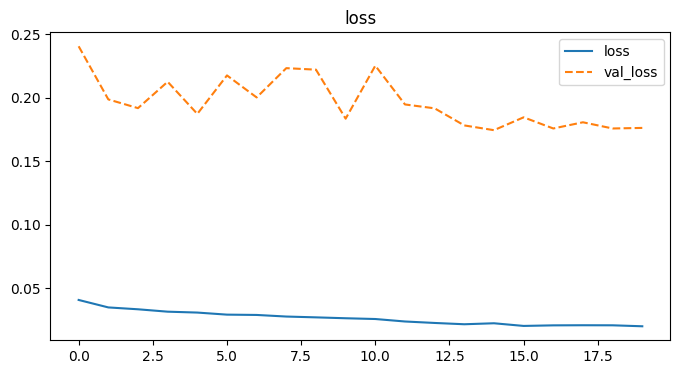

In [33]:
# 3. Build model
# harmonics, model = build_model(
    # train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range)
# harmonics = data_to_harmonics_function(train_data, data_range)
# processed_signal_FFT = mix_harmonics_function(
#     harmonics, n_harm_lower_limit, n_harm_upper_limit)
# processed_signal = processed_signal_FFT

input_shape = (x_train[list(x_train.keys())[0]].shape[1],1)
model = build_Lstm_model(train_data, prediction_day, input_shape)

history = train_Lstm_model(train_data, model, x_train, y_train)
# Loss
fig, ax = plt.subplots(figsize=(8,4))
plt.title('loss')
plt.plot(history['data_0'].history['loss'], label='loss')
plt.plot(history['data_0'].history['val_loss'], label='val_loss', linestyle='--')
plt.legend()
plt.show()


In [34]:
processed_signal = predicting_creat_processed_signal_Lstm(x_test, test_data, model)
find_signal_pv_function(processed_signal, pv_range)
find_signal_lead_train_function(train_data, processed_signal)

1/1 [==============================] - 1s 1s/step


In [35]:
# 4. Select model
# errors, best_fit_harm, best_error, first_date, lead, pv = select_model(test_data,
#                                                                         model, fit_method)
errors = get_fit_error_function(processed_signal, fit_method)
best_fit_harm, best_error = get_best_fit_harm_function(
    processed_signal, errors)
find_signal_lead_test_function(test_data, processed_signal)
first_date, lead, pv = get_first_lead_function(
    processed_signal, best_fit_harm)


In [36]:
# 5. Evaluate model
# result_table, final_error = evaluate_model(
#     model, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range)
result_table = built_result_table_function(
    processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm)
result_table_process_Lstm_function(
    result_table, all_data, first_date, data_range)
final_error = compute_final_error_function(result_table)
print('final_error = ', final_error)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(result_table)

final_error =  11.5
            s_date      t_date  lead    ans_date      pv  error best_fit
data_0  2020-01-02  2020-01-03  10.0  2020-01-17    peak   8.61        0
data_1  2020-01-16  2020-01-29   2.0  2020-01-31  valley   9.74        0
data_2  2020-01-31  2020-02-20 -13.0  2020-01-31  valley   9.78        0
data_3  2020-02-14  2020-02-21  21.0  2020-03-23  valley   9.12        0
data_4  2020-03-02  2020-03-17   4.0  2020-03-23  valley  10.45        0
data_5  2020-03-16  2020-03-18   3.0  2020-03-23  valley  10.44        0
data_6  2020-03-30  2020-04-01  19.0  2020-04-29    peak  11.14        0
data_7  2020-04-14  2020-04-20   7.0  2020-04-29    peak   6.48        0
data_8  2020-04-28  2020-05-05  23.0  2020-06-08    peak   9.18        0
data_9  2020-05-12  2020-05-19  13.0  2020-06-08    peak   9.09        0


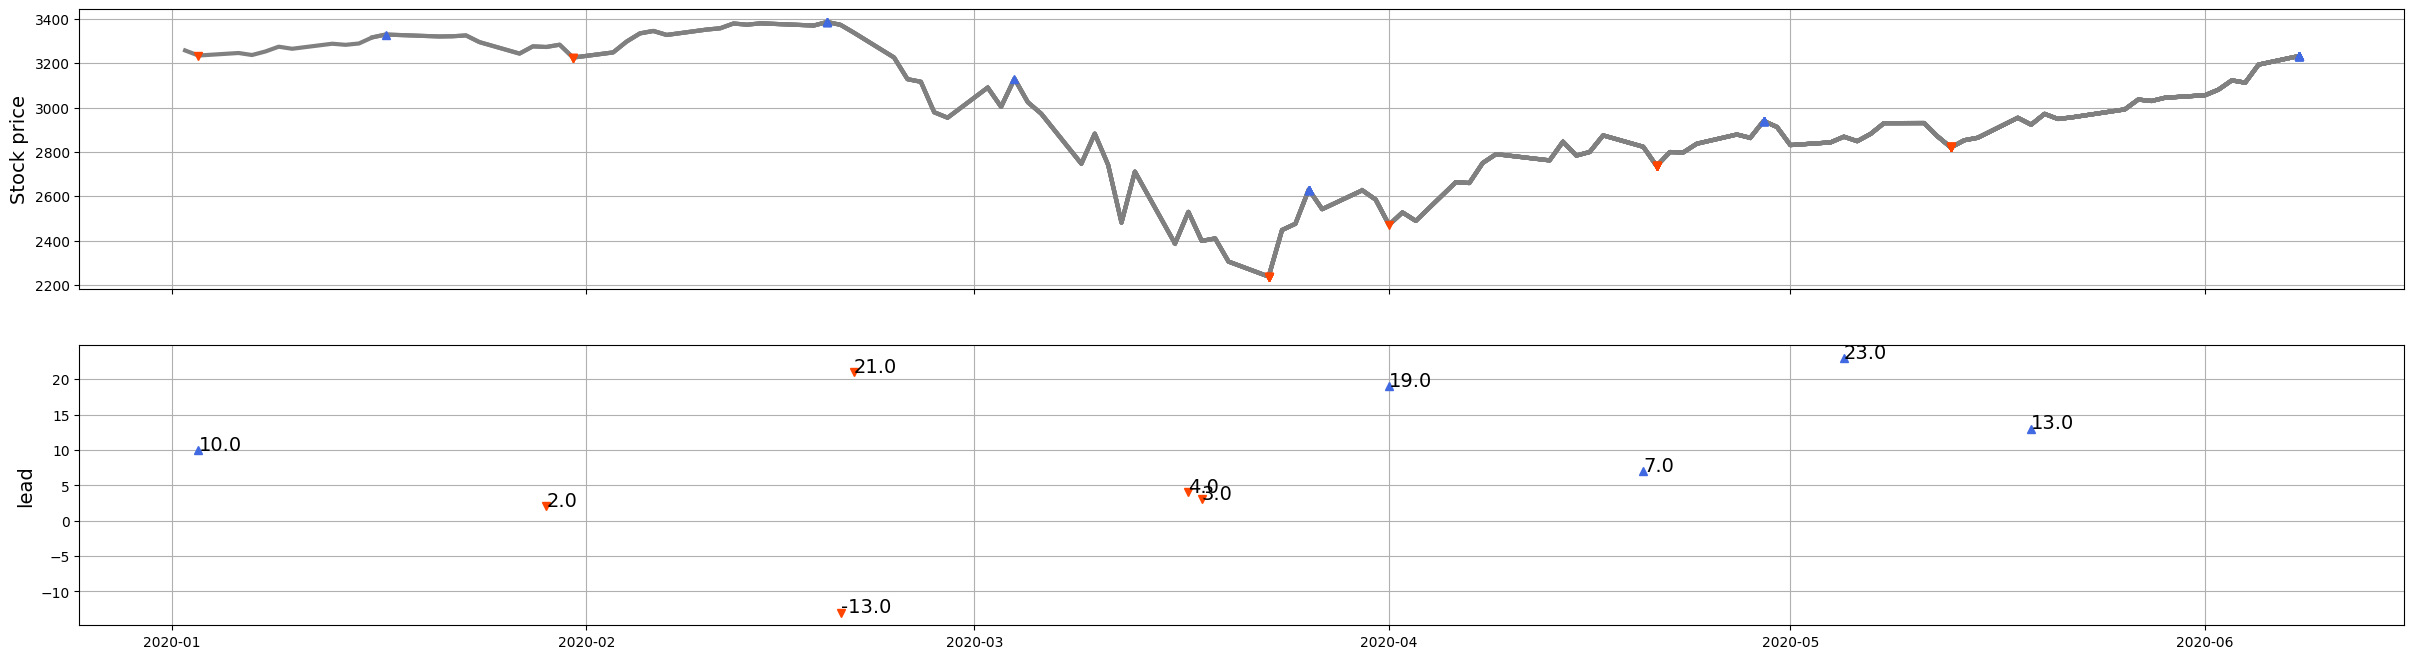

In [37]:
draw_plot_result_table(test_data, all_data, result_table, pv_range)

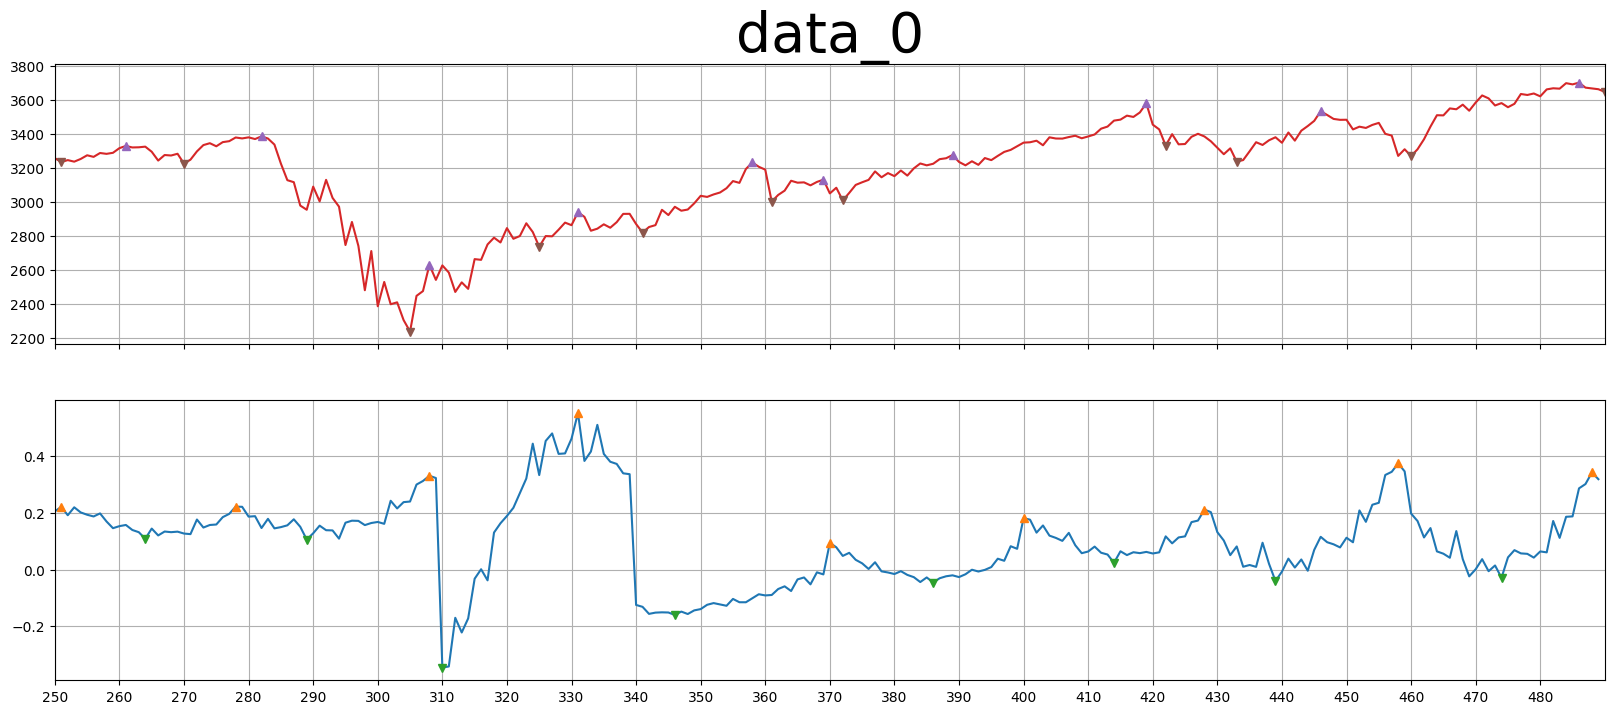

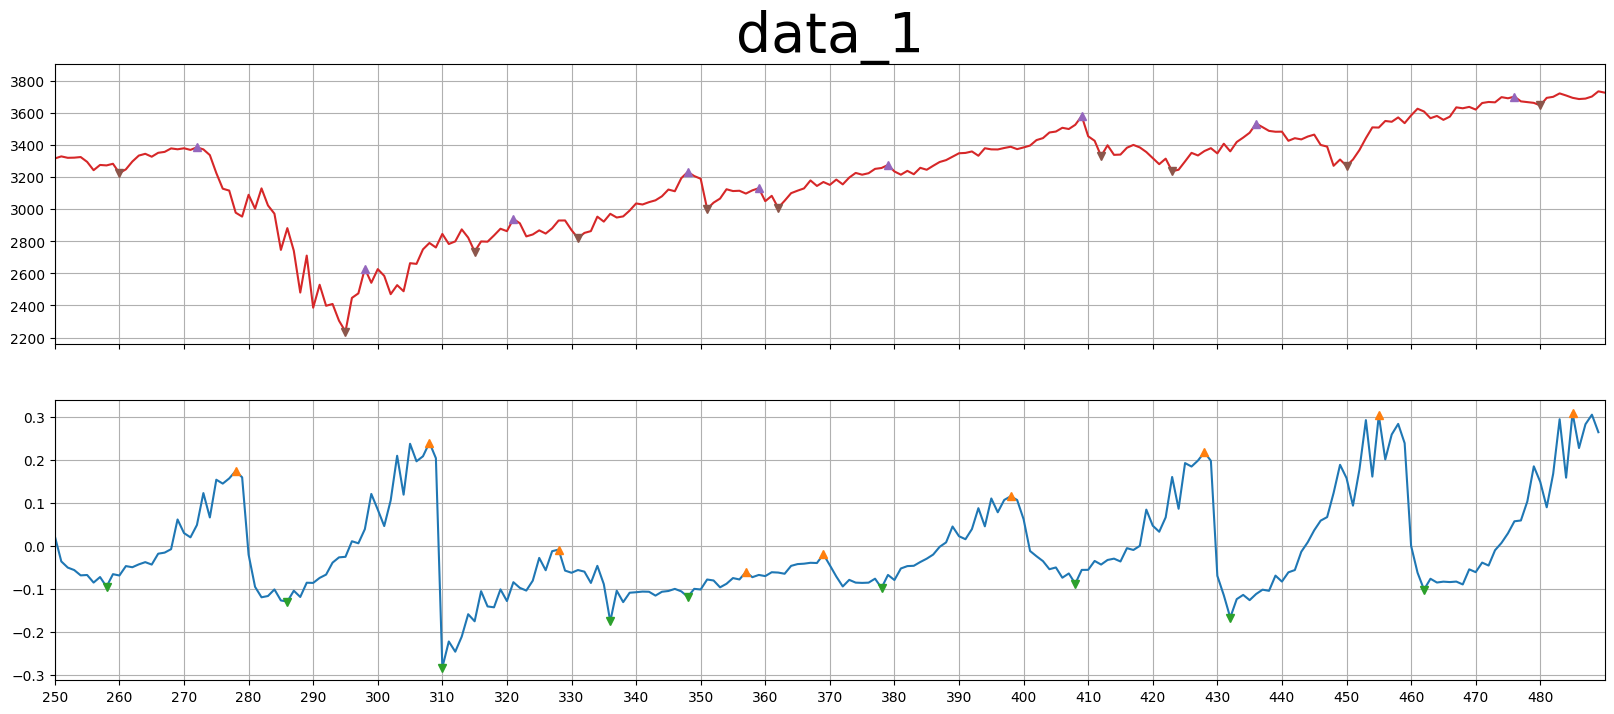

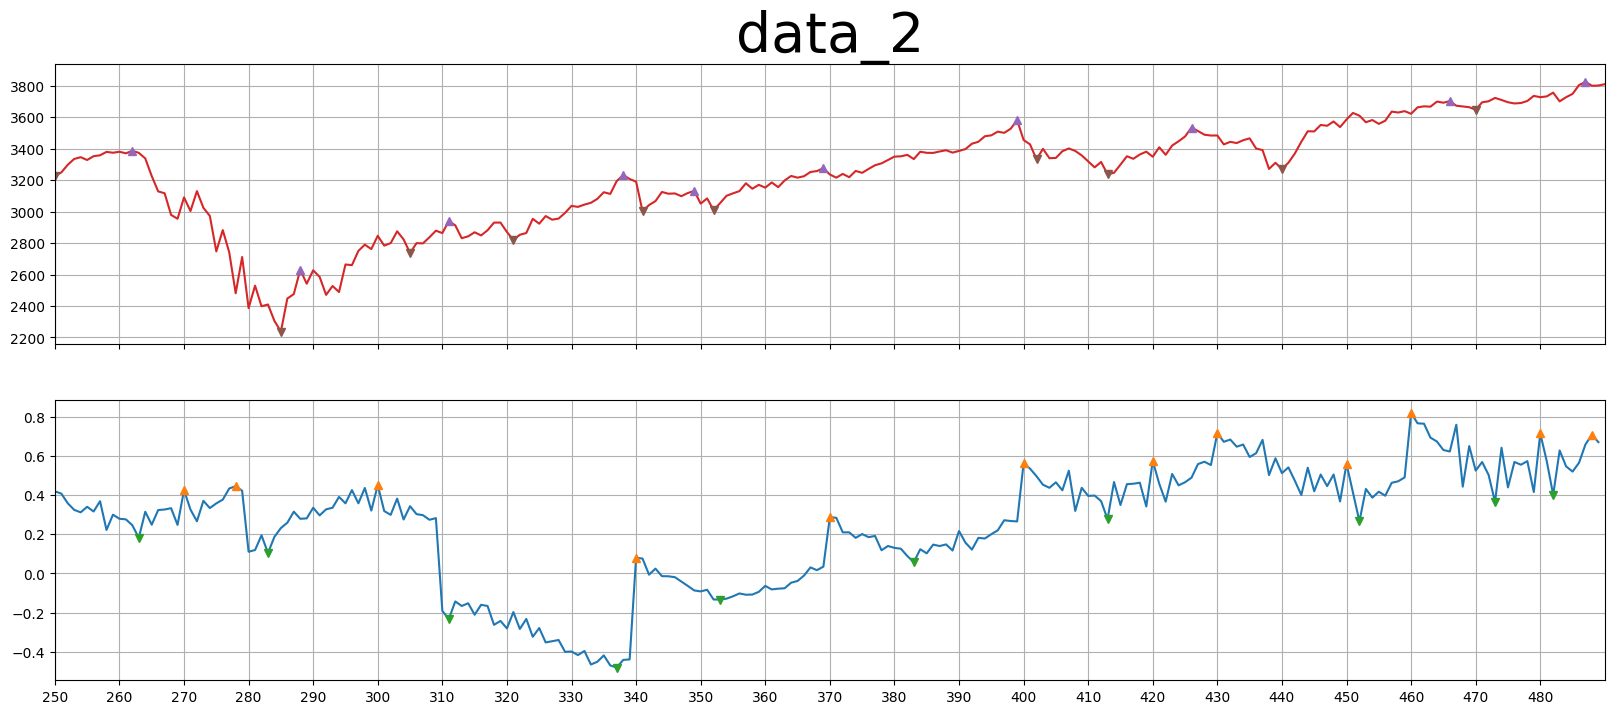

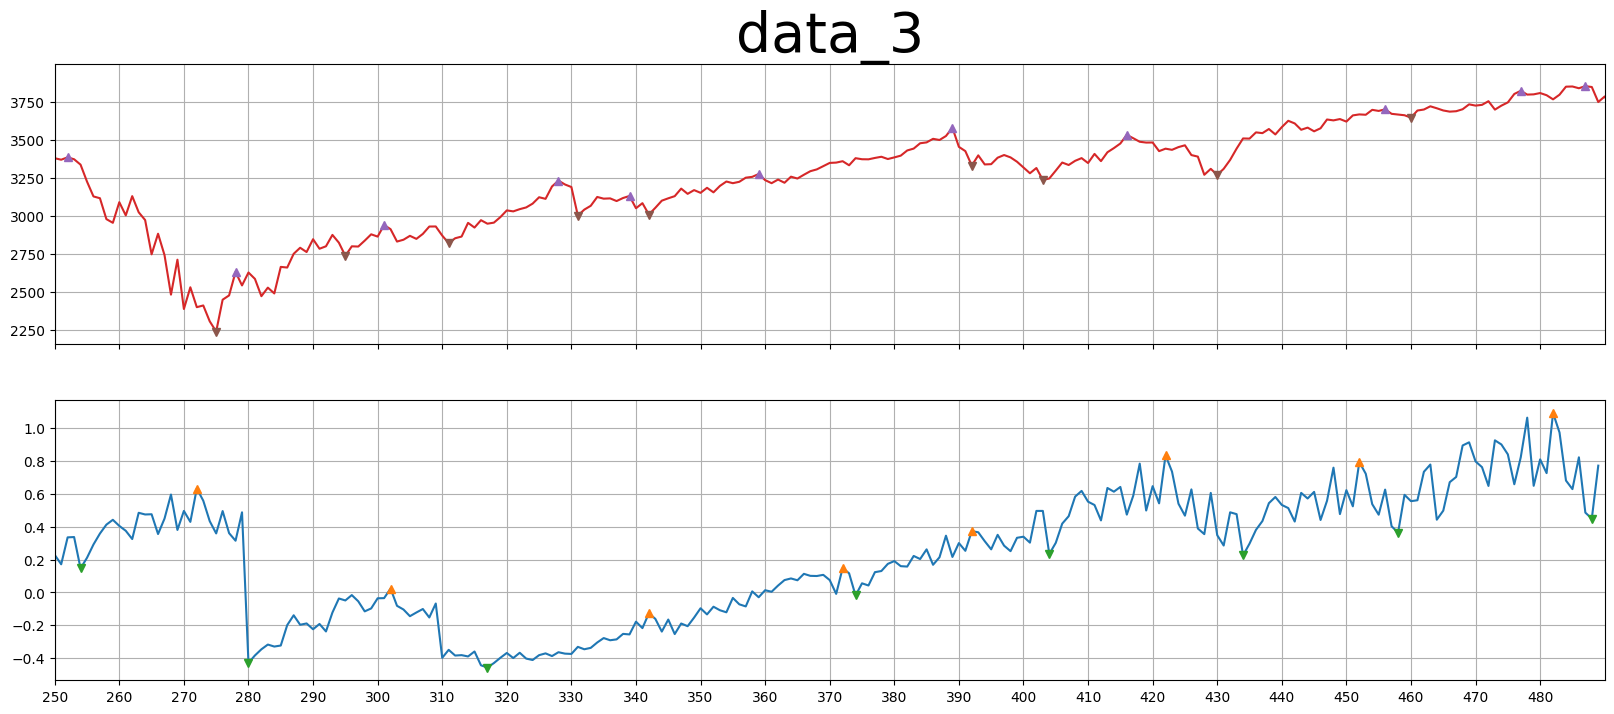

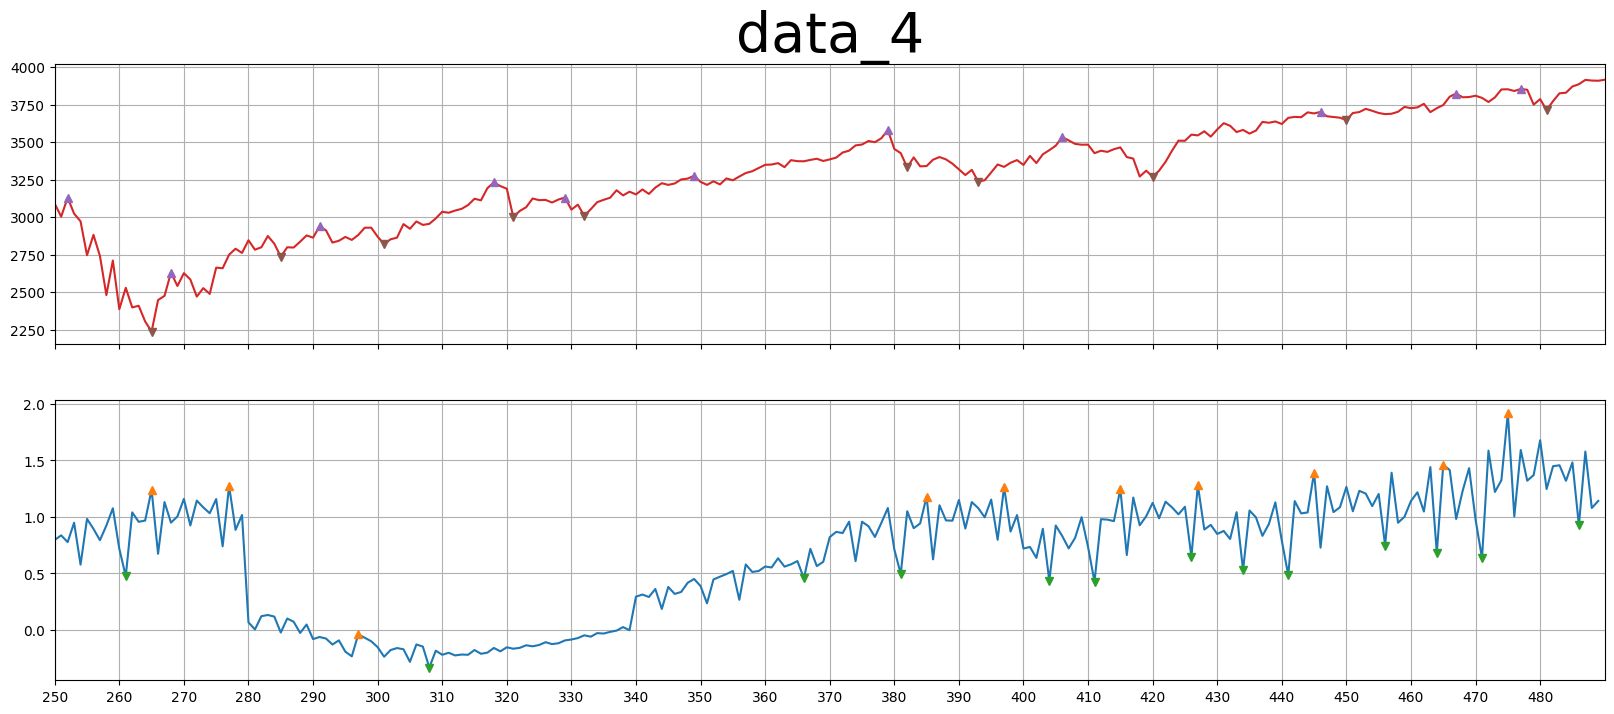

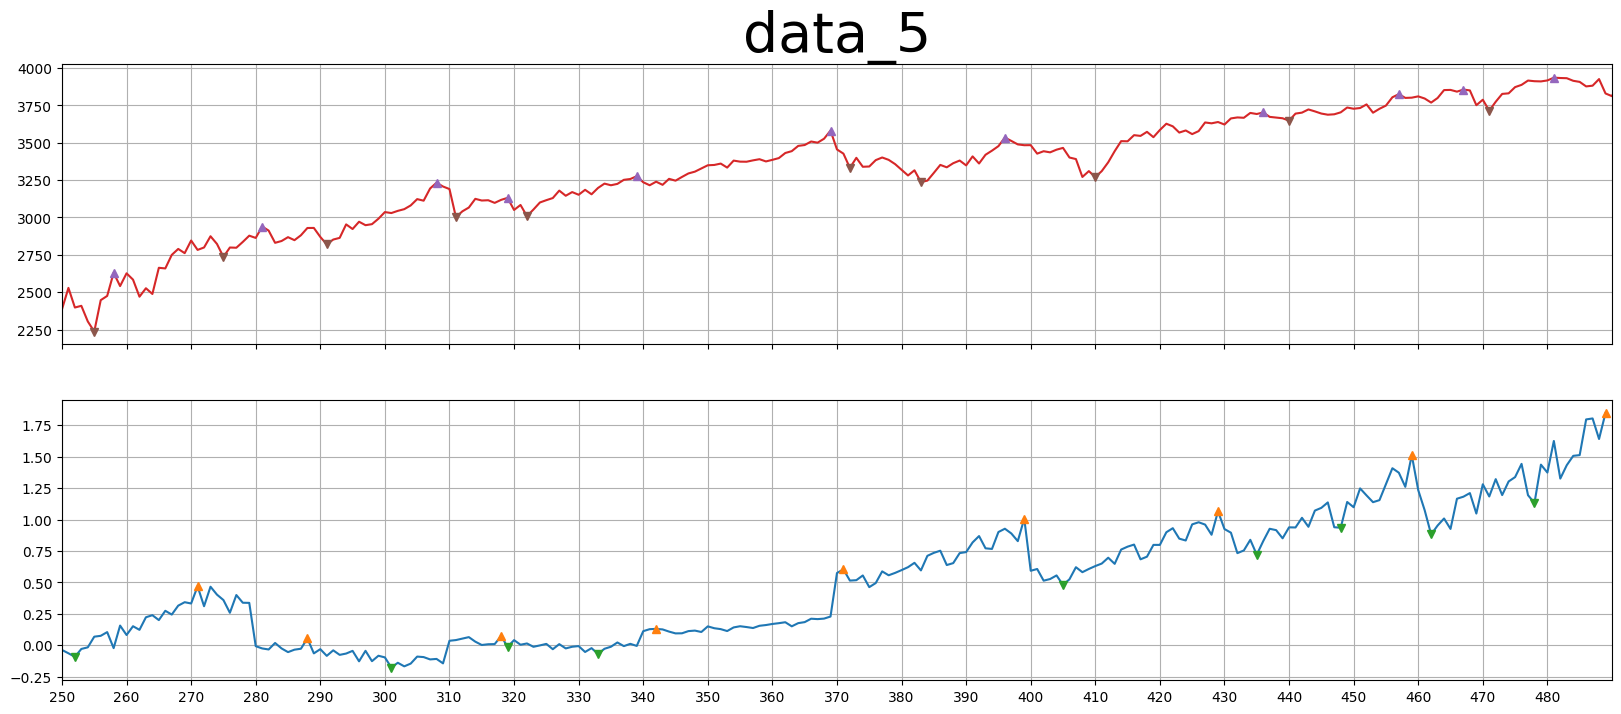

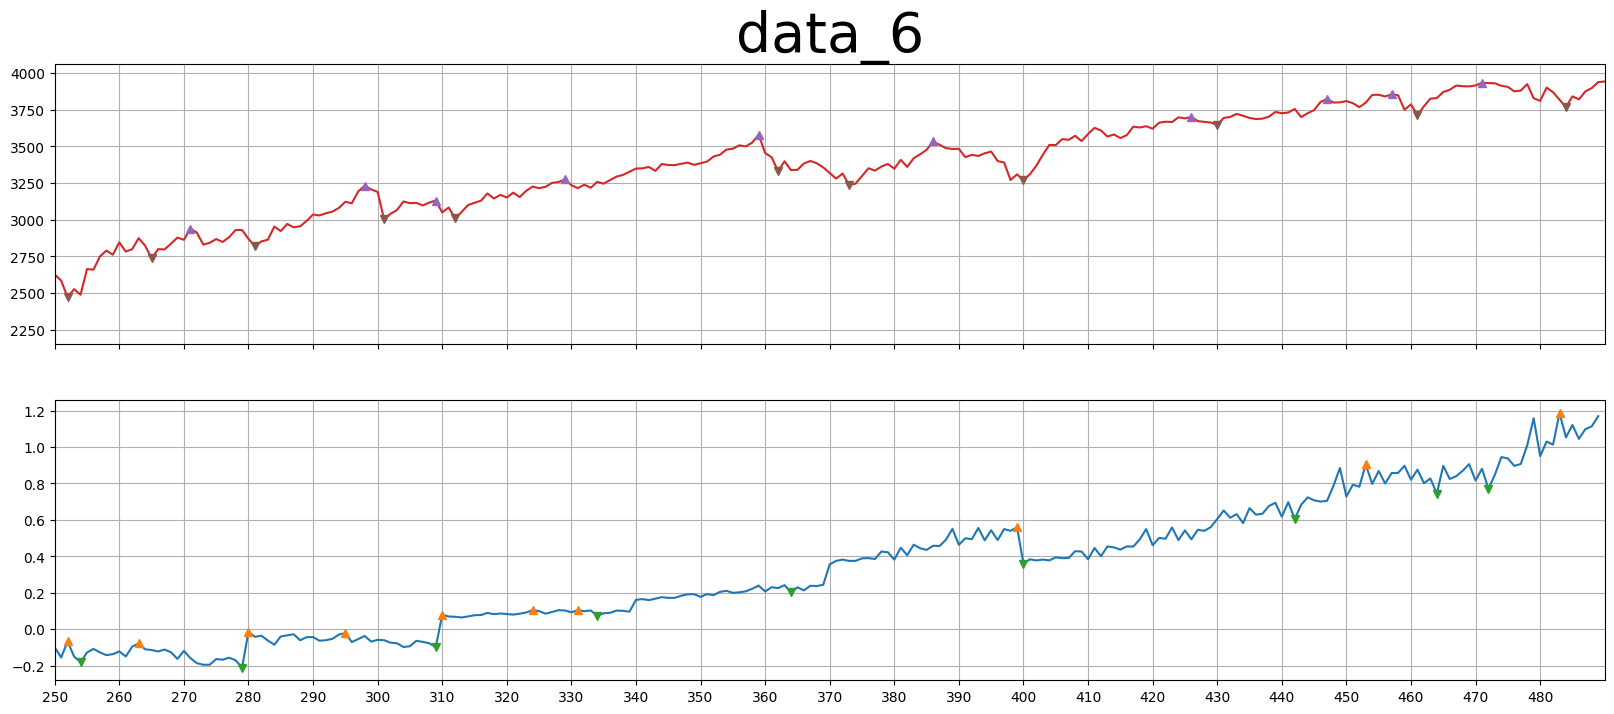

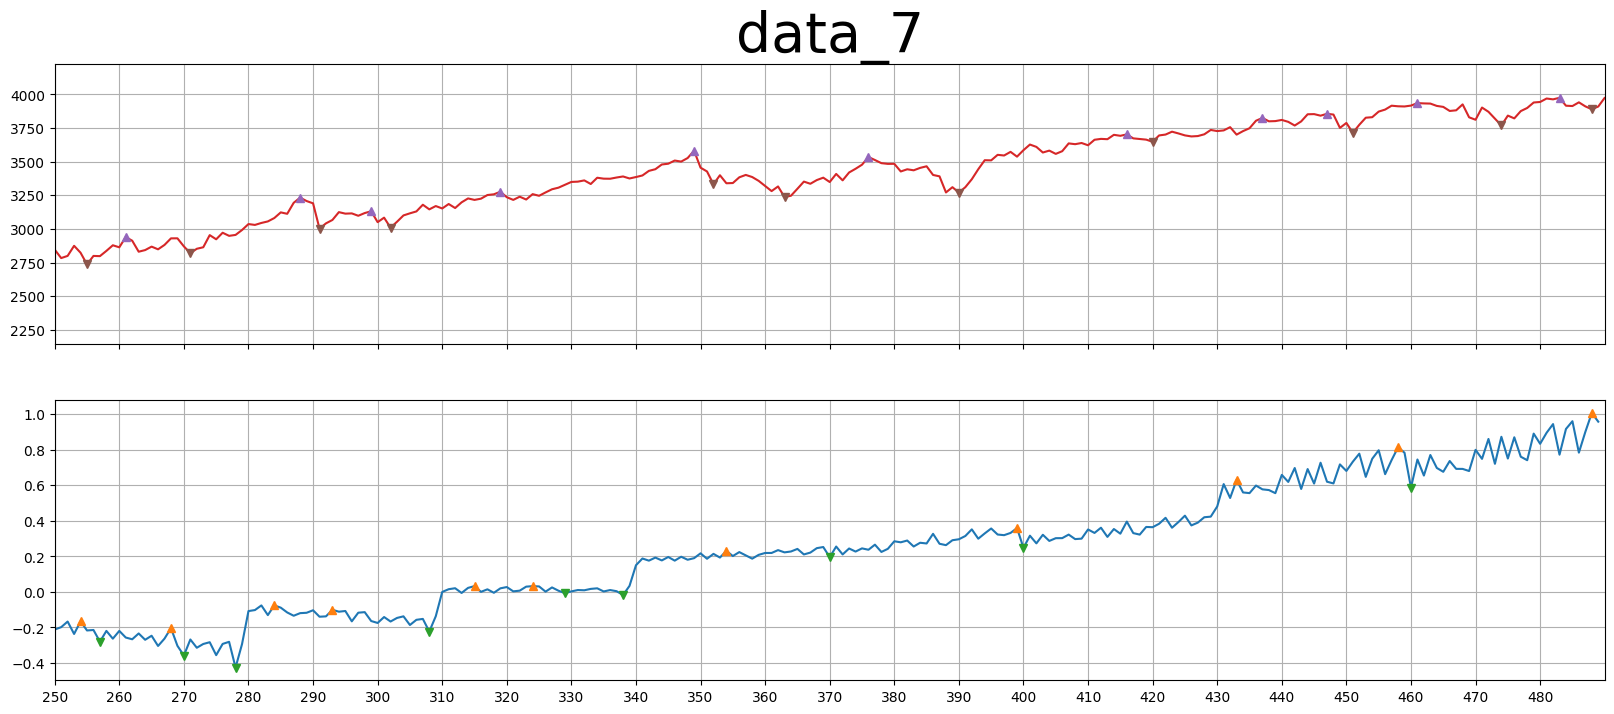

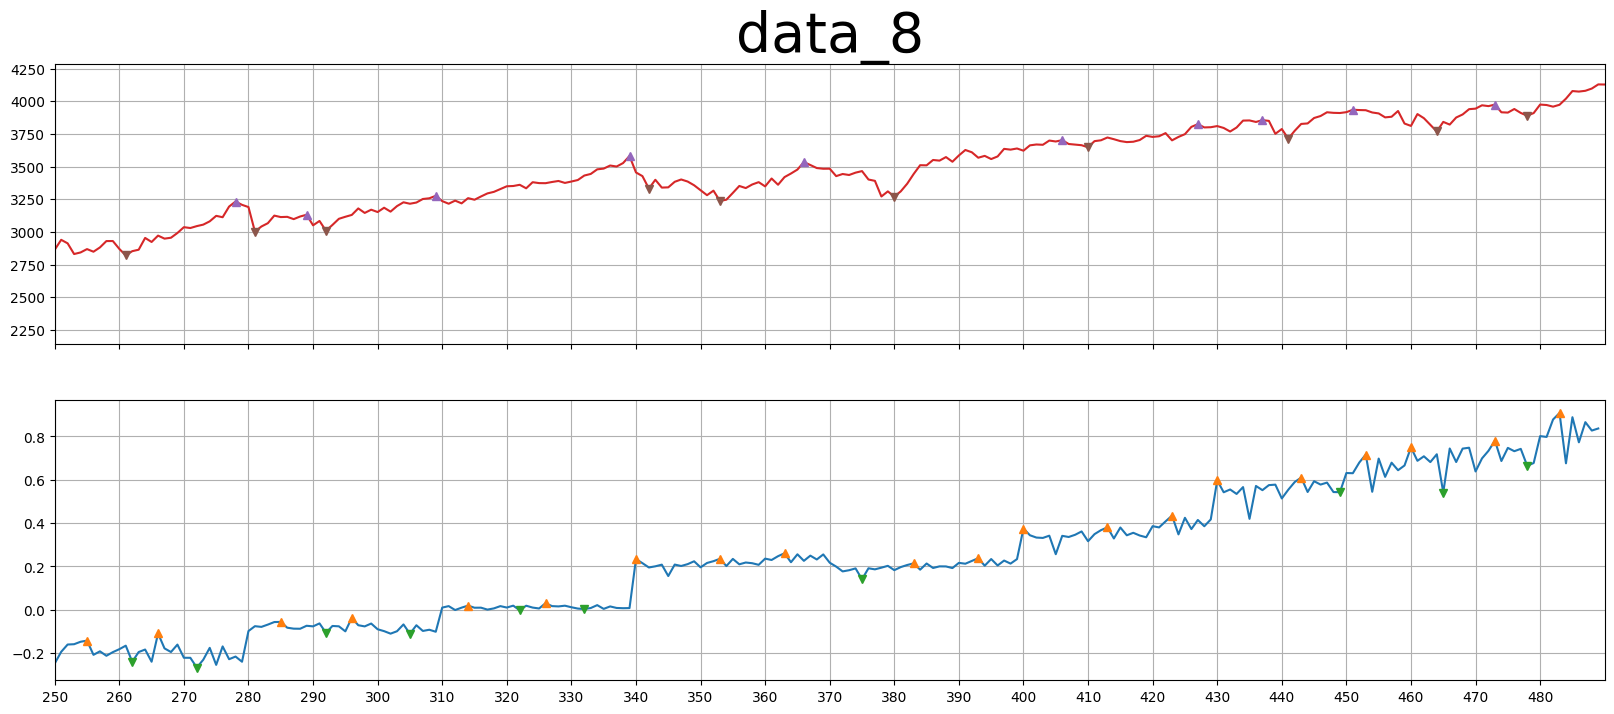

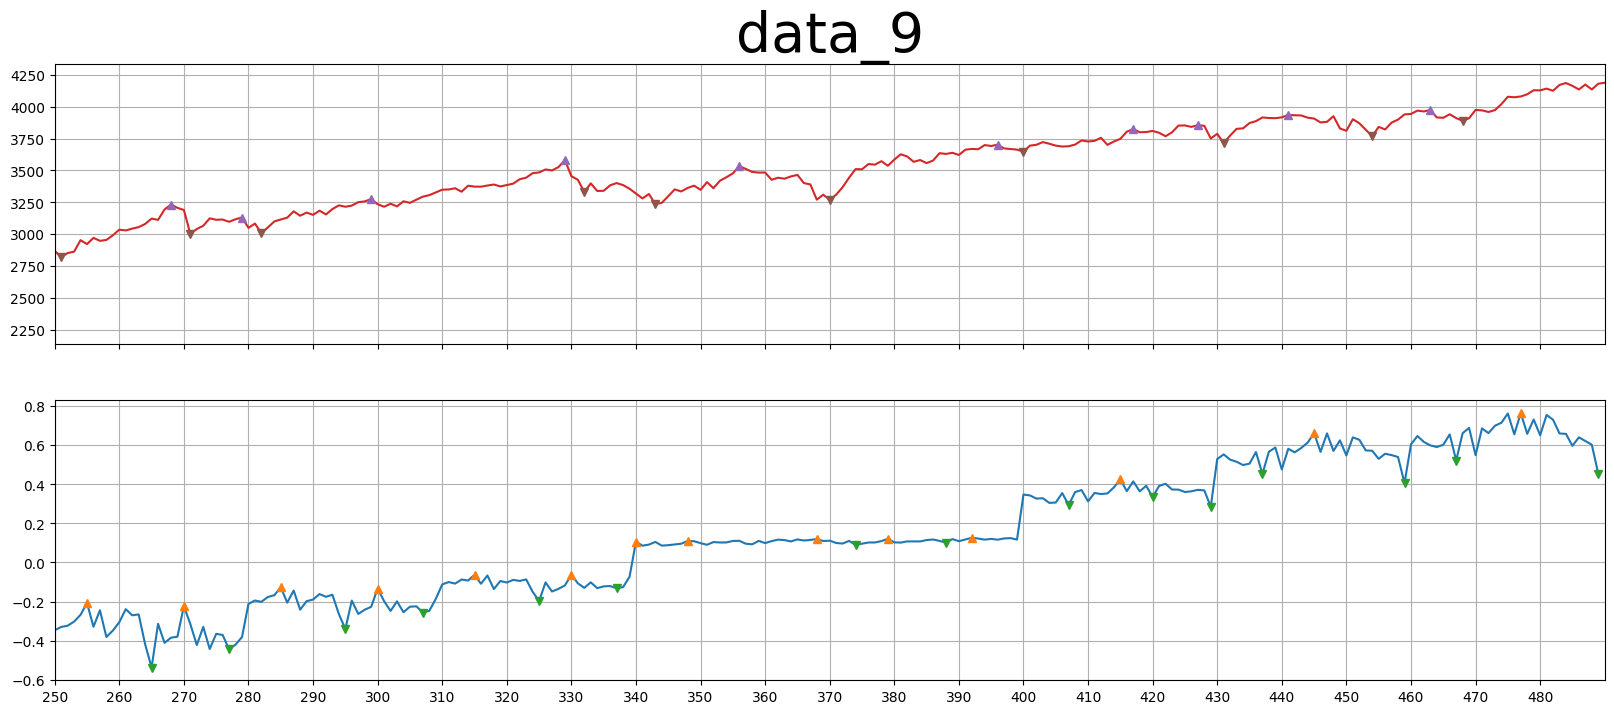

In [38]:
for i in processed_signal:
    fig, axes = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
    axes[0].set_title(i, fontsize=40)
    axes[0].plot(range(0, len(train_data[i])), train_data[i]['Close'])
    axes[0].plot(range(0, len(train_data[i])), train_data[i]['peaks'], '^')
    axes[0].plot(range(0, len(train_data[i])), train_data[i]['valleys'], 'v')
    axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['Close'])
    axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['peaks'], '^')
    axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['valleys'], 'v')
    axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['Close'])
    axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['peaks'], '^')
    axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['valleys'], 'v')
    plt.xlim(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]]))
    axes[0].grid()
    axes[1].grid()
    plt.xticks(np.arange(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]]), step=10))
    plt.show()

In [39]:
def kbar(open, close, high, low, pos):
    if close > open:             # 上漲
        color='red'                 # 紅 K 棒
        height=close - open   # 高度=收盤-開盤
        bottom=open             # 底部=開盤
    else:                               # 下跌
        color='green'              # 綠 k 棒
        height=open - close   # 高度=開盤-收盤
        bottom=close             # 底部=收盤
    # 繪製 k 棒實體      
    plt.bar(pos, height=height,bottom=bottom, width=1, color=color)
    # 繪製 k 棒上下影線
    plt.vlines(pos, high, low, color=color)

In [40]:
def draw_profit_plot(profit_table, pv_range):
    date_list = sorted(
        list(profit_table['in_date']) + list(profit_table['out_date']))
    plot_data = all_data.loc[date_list[0]:date_list[-1]]
    find_data_pv_function(plot_data, pv_range)
    plt.figure(figsize=(20, 8))
    for i in plot_data.index:
        kbar(plot_data['Open'].loc[i], plot_data['Close'].loc[i], plot_data['High'].loc[i], plot_data['Low'].loc[i], i)
    # plt.plot(plot_data['peaks'], '^', label='peaks', c='royalblue')
    # plt.plot(plot_data['valleys'], 'v', label='valleys', c='orangered')
    for i in profit_table.index:
        if profit_table.loc[i, 'pv'] == 'peak':
            plt.annotate('', xy=(profit_table.loc[i, 'out_date'], profit_table.loc[i, 'out_price']),
                            xytext=(profit_table.loc[i, 'in_date'], profit_table.loc[i, 'in_price']),
                            arrowprops=dict(facecolor='green', arrowstyle='simple'))

        elif profit_table.loc[i, 'pv'] == 'valley':
            plt.annotate('', xy=(profit_table.loc[i, 'out_date'], profit_table.loc[i, 'out_price']),
                            xytext=(profit_table.loc[i, 'in_date'], profit_table.loc[i, 'in_price']),
                            arrowprops=dict(facecolor='red', arrowstyle='simple'))
        if 'strategy' in profit_table.columns:
            if profit_table.loc[i, 'strategy'] == 'stop_profit':
                plt.hlines(profit_table.loc[i, 'strategy_price'], profit_table.loc[i, 'in_date'], profit_table.loc[i, 'out_date'], color='red')
            elif profit_table.loc[i, 'strategy'] == 'stop_loss':
                plt.hlines(profit_table.loc[i, 'strategy_price'], profit_table.loc[i, 'in_date'], profit_table.loc[i, 'out_date'], color='green')
            
        # plt.annotate(f'{i}', (profit_table.loc[i, 'in_date'], profit_table.loc[i, 'in_price']-100), fontsize=14, c='black')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.grid()
    plt.legend()
    plt.show()

In [41]:
def build_profit_table_method_1(result_table):
    profit_table = pd.DataFrame(columns=['in_date', 'in_price', 'out_date', 'out_price', 'pv', 'profit'])
    total_profit = 0
    for i in result_table.index:
        in_price = all_data['Open'].iloc[all_data.index.get_loc(result_table.loc[i, 't_date'])]
        out_price = all_data['Close'].iloc[all_data.index.get_loc(result_table.loc[i, 't_date'])+pv_range]
        if result_table.loc[i, 'pv'] == 'valley':
            profit = out_price - in_price
            profit_table.loc[i, 'pv'] = 'valley'
        else:
            profit = in_price - out_price
            profit_table.loc[i, 'pv'] = 'peak'
        profit_table.loc[i, 'in_date'] = result_table.loc[i, 't_date']
        profit_table.loc[i, 'in_price'] = in_price
        profit_table.loc[i, 'out_date'] = all_data.iloc[all_data.index.get_loc(result_table.loc[i, 't_date'])+pv_range].name
        profit_table.loc[i, 'out_price'] = out_price
        profit_table.loc[i, 'profit'] = profit
        total_profit += profit
    return total_profit, profit_table

In [42]:
total_profit, profit_table = build_profit_table_method_1(result_table)
print('total_profit =', total_profit)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(profit_table)

total_profit = -793.289306640625
           in_date in_price    out_date out_price      pv  profit
data_0  2020-01-03  3226.36  2020-01-14   3283.15    peak  -56.79
data_1  2020-01-29  3289.46  2020-02-07   3327.71  valley   38.25
data_2  2020-02-20  3380.45  2020-03-02   3090.23  valley -290.22
data_3  2020-02-21   3360.5  2020-03-03   3003.37  valley -357.13
data_4  2020-03-17  2425.66  2020-03-26   2630.07  valley  204.41
data_5  2020-03-18   2436.5  2020-03-27   2541.47  valley  104.97
data_6  2020-04-01  2498.08  2020-04-13   2761.63    peak -263.55
data_7  2020-04-20  2845.62  2020-04-29   2939.51    peak  -93.89
data_8  2020-05-05  2868.88  2020-05-14    2852.5    peak   16.38
data_9  2020-05-19  2948.59  2020-05-29   3044.31    peak  -95.72


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


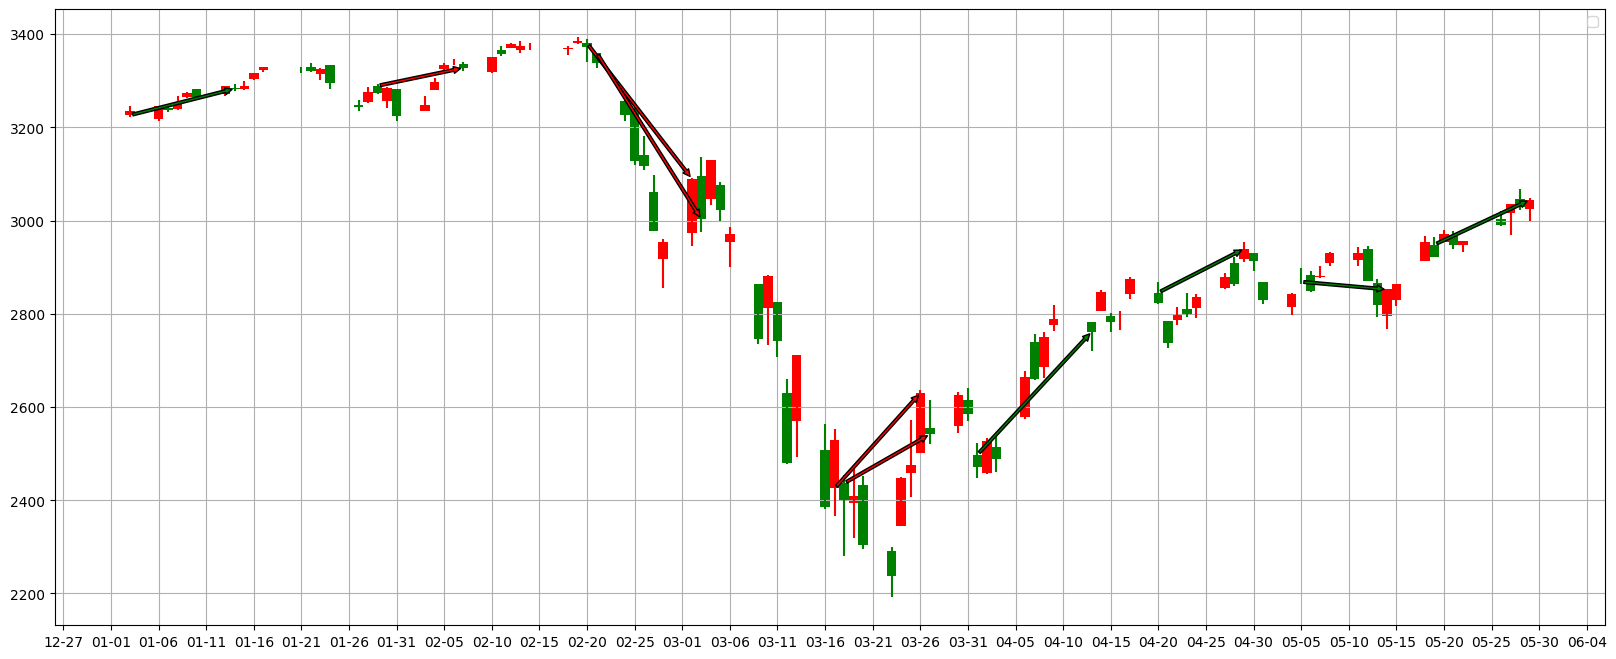

In [43]:
draw_profit_plot(profit_table, pv_range)

In [44]:
def build_profit_table_method_2(result_table, profit_percentage, loss_percentage):
    '''percentage:fioat
    '''
    profit_table = pd.DataFrame(columns=['in_date', 'in_price', 'out_date', 'out_price', 'pv', 'profit', 'strategy', 'strategy_price'])
    total_profit = 0
    for i in result_table.index:
        in_price = all_data['Open'].iloc[all_data.index.get_loc(result_table.loc[i, 't_date'])]
        if result_table.loc[i, 'pv'] == 'valley':
            stop_profit_price = in_price*(1+profit_percentage)
            stop_loss_price = in_price*(1-loss_percentage)
        else:
            stop_profit_price = in_price*(1-profit_percentage)
            stop_loss_price = in_price*(1+loss_percentage)

        # print(in_price, stop_loss_price, stop_profit_price)
        start_index = all_data.index.get_loc(result_table.loc[i, 't_date'])
        end_index = all_data.index.get_loc(result_table.loc[i, 't_date'])+pv_range
        trade_data = all_data.iloc[start_index:end_index]
        # check out_price
        out_price = all_data['Close'].iloc[end_index]
        profit_table.loc[i, 'out_date'] = all_data.iloc[end_index].name
        for j in trade_data.index:
            high = trade_data['High'].loc[j]
            low = trade_data['Low'].loc[j]
            if result_table.loc[i, 'pv'] == 'valley':
                if high>=stop_profit_price:
                    out_price = stop_profit_price
                    profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                    profit_table.loc[i, 'strategy'] = 'stop_profit'
                    profit_table.loc[i, 'strategy_price'] = stop_profit_price
                    break
                elif low<=stop_loss_price:
                    out_price = stop_loss_price
                    profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                    profit_table.loc[i, 'strategy'] = 'stop_loss'
                    profit_table.loc[i, 'strategy_price'] = stop_loss_price
                    break
            elif result_table.loc[i, 'pv'] == 'peak':
                    if low<=stop_profit_price:
                        out_price = stop_profit_price
                        profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                        profit_table.loc[i, 'strategy'] = 'stop_profit'
                        profit_table.loc[i, 'strategy_price'] = stop_profit_price
                        break
                    elif high>=stop_loss_price:
                        out_price = stop_loss_price
                        profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                        profit_table.loc[i, 'strategy'] = 'stop_loss'
                        profit_table.loc[i, 'strategy_price'] = stop_loss_price
                        break

        if result_table.loc[i, 'pv'] == 'valley':
            profit = out_price - in_price
            profit_table.loc[i, 'pv'] = 'valley'
        else:
            profit = in_price - out_price
            profit_table.loc[i, 'pv'] = 'peak'
        profit_table.loc[i, 'in_date'] = result_table.loc[i, 't_date']
        profit_table.loc[i, 'in_price'] = in_price
        
        profit_table.loc[i, 'out_price'] = out_price
        profit_table.loc[i, 'profit'] = profit
        total_profit += profit
    return total_profit, profit_table

In [45]:
total_profit, profit_table = build_profit_table_method_2(result_table, profit_percentage, loss_percentage)


In [46]:
print('total_profit =', total_profit)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(profit_table)

total_profit = -1154.9126220703124
           in_date in_price    out_date out_price      pv   profit   strategy  \
data_0  2020-01-03  3226.36  2020-01-14   3283.15    peak   -56.79        NaN   
data_1  2020-01-29  3289.46  2020-02-07   3327.71  valley    38.25        NaN   
data_2  2020-02-20  3380.45  2020-02-27  3042.405  valley -338.045  stop_loss   
data_3  2020-02-21   3360.5  2020-02-27   3024.45  valley  -336.05  stop_loss   
data_4  2020-03-17  2425.66  2020-03-26   2630.07  valley   204.41        NaN   
data_5  2020-03-18   2436.5  2020-03-23   2192.85  valley  -243.65  stop_loss   
data_6  2020-04-01  2498.08  2020-04-07  2747.888    peak -249.808  stop_loss   
data_7  2020-04-20  2845.62  2020-04-29   2939.51    peak   -93.89        NaN   
data_8  2020-05-05  2868.88  2020-05-14    2852.5    peak    16.38        NaN   
data_9  2020-05-19  2948.59  2020-05-29   3044.31    peak   -95.72        NaN   

       strategy_price  
data_0            NaN  
data_1            NaN  
d

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


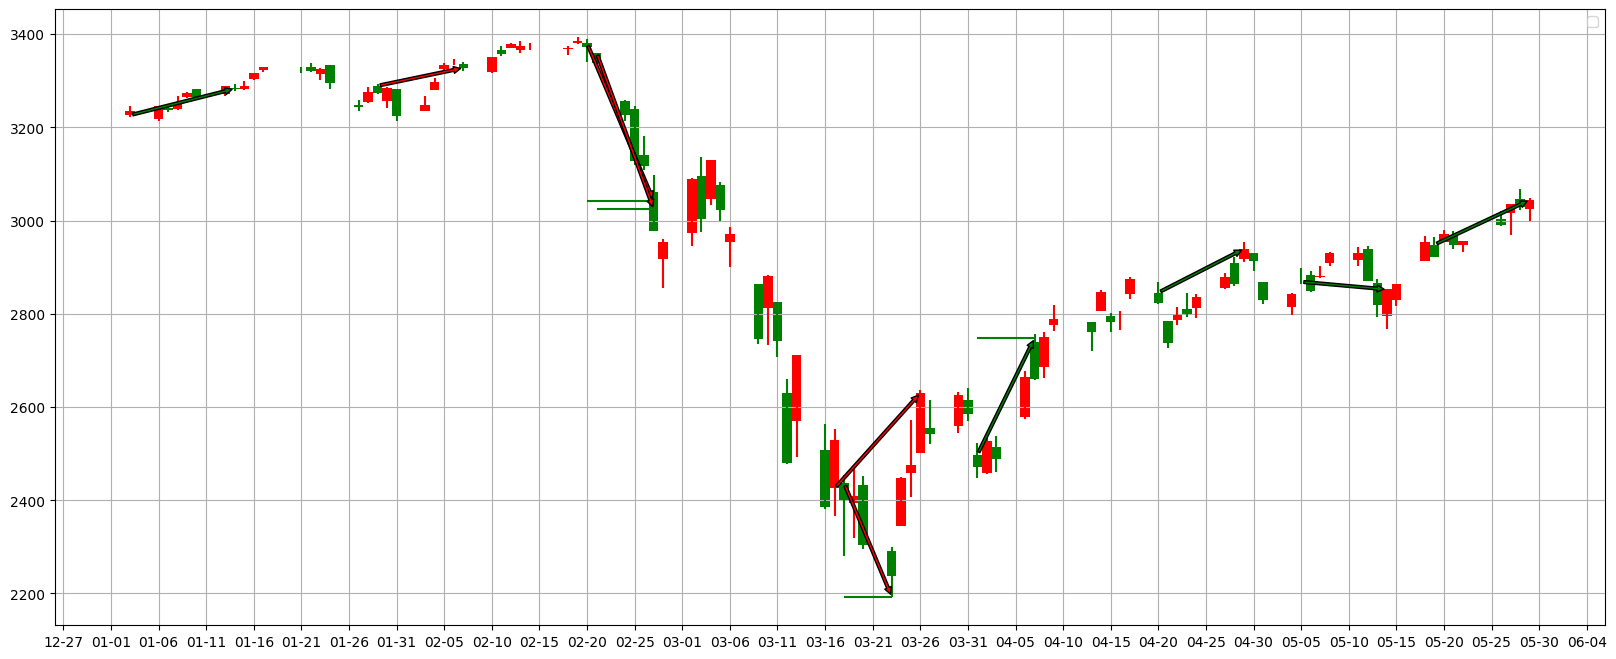

In [47]:
draw_profit_plot(profit_table, pv_range)

In [48]:
def build_profit_table_method_3(result_table, profit_percentage, loss_percentage):
    '''percentage:fioat
    '''
    profit_table = pd.DataFrame(columns=['in_date', 'in_price', 'out_date', 'out_price', 'pv', 'profit', 'strategy', 'strategy_price'])
    total_profit = 0
    for i in result_table.index:
        in_price = all_data['Open'].iloc[all_data.index.get_loc(result_table.loc[i, 't_date'])]
        # print(in_price, stop_loss_price, stop_profit_price)
        start_index = all_data.index.get_loc(result_table.loc[i, 't_date'])
        end_index = all_data.index.get_loc(result_table.loc[i, 't_date'])+pv_range
        trade_data = all_data.iloc[start_index:end_index]
        # check out_price
        out_price = all_data['Close'].iloc[end_index]
        profit_table.loc[i, 'out_date'] = all_data.iloc[end_index].name
        yesterday_close = all_data['Close'].iloc[all_data.index.get_loc(result_table.loc[i, 't_date'])-1]
        for j in trade_data.index:
            if result_table.loc[i, 'pv'] == 'valley':
                stop_profit_price = yesterday_close*(1+profit_percentage)
                stop_loss_price = yesterday_close*(1-loss_percentage)
            else:
                stop_profit_price = yesterday_close*(1-profit_percentage)
                stop_loss_price = yesterday_close*(1+loss_percentage)
            yesterday_close = trade_data['Close'].loc[j]
            high = trade_data['High'].loc[j]
            low = trade_data['Low'].loc[j]
            if result_table.loc[i, 'pv'] == 'valley':
                if high>=stop_profit_price:
                    out_price = stop_profit_price
                    profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                    profit_table.loc[i, 'strategy'] = 'stop_profit'
                    profit_table.loc[i, 'strategy_price'] = stop_profit_price
                    break
                elif low<=stop_loss_price:
                    out_price = stop_loss_price
                    profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                    profit_table.loc[i, 'strategy'] = 'stop_loss'
                    profit_table.loc[i, 'strategy_price'] = stop_loss_price
                    break
            elif result_table.loc[i, 'pv'] == 'peak':
                    if low<=stop_profit_price:
                        out_price = stop_profit_price
                        profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                        profit_table.loc[i, 'strategy'] = 'stop_profit'
                        profit_table.loc[i, 'strategy_price'] = stop_profit_price
                        break
                    elif high>=stop_loss_price:
                        out_price = stop_loss_price
                        profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                        profit_table.loc[i, 'strategy'] = 'stop_loss'
                        profit_table.loc[i, 'strategy_price'] = stop_loss_price
                        break

        if result_table.loc[i, 'pv'] == 'valley':
            profit = out_price - in_price
            profit_table.loc[i, 'pv'] = 'valley'
        else:
            profit = in_price - out_price
            profit_table.loc[i, 'pv'] = 'peak'
        profit_table.loc[i, 'in_date'] = result_table.loc[i, 't_date']
        profit_table.loc[i, 'in_price'] = in_price
        
        profit_table.loc[i, 'out_price'] = out_price
        profit_table.loc[i, 'profit'] = profit
        total_profit += profit
    return total_profit, profit_table

In [49]:
total_profit, profit_table = build_profit_table_method_3(result_table, profit_percentage, loss_percentage)


In [50]:
print('total_profit =', total_profit)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(profit_table)

total_profit = -793.289306640625
           in_date in_price    out_date out_price      pv  profit strategy  \
data_0  2020-01-03  3226.36  2020-01-14   3283.15    peak  -56.79      NaN   
data_1  2020-01-29  3289.46  2020-02-07   3327.71  valley   38.25      NaN   
data_2  2020-02-20  3380.45  2020-03-02   3090.23  valley -290.22      NaN   
data_3  2020-02-21   3360.5  2020-03-03   3003.37  valley -357.13      NaN   
data_4  2020-03-17  2425.66  2020-03-26   2630.07  valley  204.41      NaN   
data_5  2020-03-18   2436.5  2020-03-27   2541.47  valley  104.97      NaN   
data_6  2020-04-01  2498.08  2020-04-13   2761.63    peak -263.55      NaN   
data_7  2020-04-20  2845.62  2020-04-29   2939.51    peak  -93.89      NaN   
data_8  2020-05-05  2868.88  2020-05-14    2852.5    peak   16.38      NaN   
data_9  2020-05-19  2948.59  2020-05-29   3044.31    peak  -95.72      NaN   

       strategy_price  
data_0            NaN  
data_1            NaN  
data_2            NaN  
data_3      

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


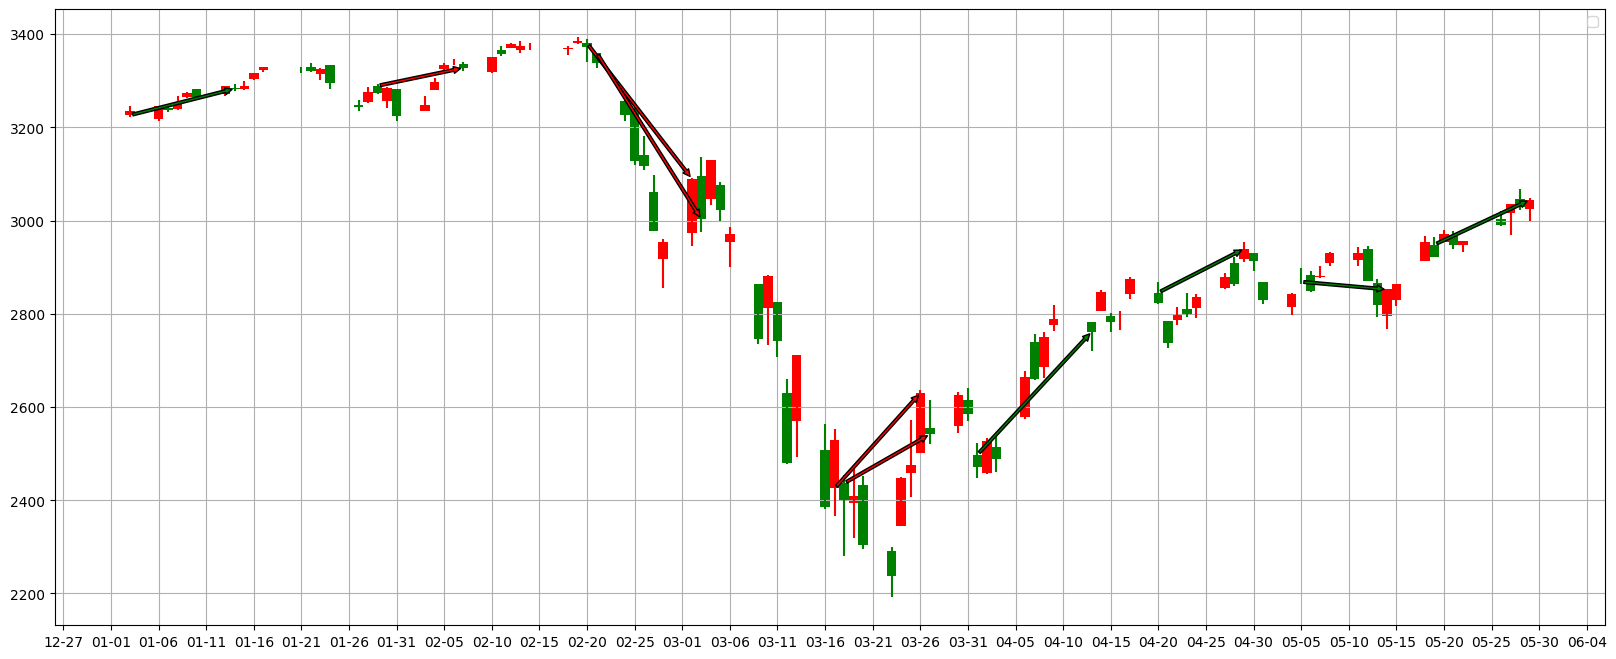

In [51]:
draw_profit_plot(profit_table, pv_range)